In [1]:
import os
os.environ["KERAS_BACKEND"] = "tensorflow"

In [2]:
import numpy as np  # for array
import pandas as pd  # for csv files and dataframe
import matplotlib.pyplot as plt  # for plotting
import seaborn as sns  # plotting
from scipy import stats
from tqdm import tqdm  # Progress bar

import time

import pickle  # To load data int disk
from prettytable import PrettyTable  # To print in tabular format

import warnings
warnings.filterwarnings("ignore")

from sklearn.preprocessing import StandardScaler  # Standardizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder  # One hot Encoder
from scipy.sparse import csr_matrix  # For sparse matrix

from sklearn.model_selection import train_test_split
# Different Models
from sklearn.linear_model import LogisticRegression, SGDClassifier  # LR
from sklearn.svm import LinearSVC  # SVM
from sklearn.tree import DecisionTreeClassifier  #DT
from sklearn.ensemble import RandomForestClassifier  # RF
import xgboost as xgb  #XGB

from sklearn.metrics import accuracy_score, confusion_matrix, make_scorer  # Scoring functions
from sklearn.metrics import auc, f1_score, roc_curve, roc_auc_score  # Scoring fns
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV  # Cross validation
from sklearn.metrics import accuracy_score
from sklearn.ensemble import VotingClassifier

from sklearn import metrics


%matplotlib inline

In [3]:
# from google.colab import drive
# drive.mount('/content/drive')
# drive_path="drive/MyDrive/"

In [4]:
drive_path="/home/dezs/projects/myIDS/datasets/"
model_path="/home/dezs/projects/myIDS/models/"

In [5]:
file_path = drive_path+"myDataset"
# Train and Test data
x_train, y_train = pickle.load(open(file_path+'/final_large_oversampled_train.pkl', 'rb'))
x_test, y_test = pickle.load(open(file_path+'/final_test.pkl', 'rb'))

# Dictionaries
saved_infos = pickle.load(open(file_path+'/saved_infos.pkl', 'rb'))
mode_dict = pickle.load(open(file_path+'/mode_dict.pkl', 'rb'))

my_params= pickle.load(open(model_path+'my_params.pkl', 'rb'))

# Standard scaler
scaler = pickle.load(open(file_path+'/scaler.pkl', 'rb'))

# Onehot encoders
ohe_proto = pickle.load(open(file_path+'/ohe_proto.pkl', 'rb'))
ohe_service = pickle.load(open(file_path+'/ohe_service.pkl', 'rb'))
ohe_state = pickle.load(open(file_path+'/ohe_state.pkl', 'rb'))

label_encoder = pickle.load(open(file_path+'/label_encoder.pkl', 'rb'))


In [6]:
class_labels = label_encoder.classes_
print(class_labels)
encoded_values = label_encoder.transform(['analysis', 'backdoor', 'dos', 'exploits', 'fuzzers', 'generic', 'normal', 'reconnaissance', 'shellcode', 'worms'])
print(encoded_values)
mapping = dict(zip(class_labels, encoded_values))
print(mapping)

['analysis' 'backdoor' 'dos' 'exploits' 'fuzzers' 'generic' 'normal'
 'reconnaissance' 'shellcode' 'worms']
[0 1 2 3 4 5 6 7 8 9]
{'analysis': np.int64(0), 'backdoor': np.int64(1), 'dos': np.int64(2), 'exploits': np.int64(3), 'fuzzers': np.int64(4), 'generic': np.int64(5), 'normal': np.int64(6), 'reconnaissance': np.int64(7), 'shellcode': np.int64(8), 'worms': np.int64(9)}


In [7]:
x_test.shape

(617826, 48)

In [8]:
x_train.shape

(2000000, 197)

## Pipeline functions

In [9]:
#------------------------------------------------------------------------------------------
# Data Cleaning
#------------------------------------------------------------------------------------------
def clean_data(data):
    '''
    Cleans given raw data. Performs various cleaning, removes Null and wrong values.
    Check for columns datatype and fix them.
    '''
    numerical_col = data.select_dtypes(include=np.number).columns  # All the numerical columns list
    categorical_col = data.select_dtypes(exclude=np.number).columns  # All the categorical columns list

    # Cleaning the data
    for col in data.columns:
        val = mode_dict[col]  # Mode value of the column in train data
        data[col] = data[col].fillna(value=val)
        data[col] = data[col].replace(' ', value=val)
        data[col] = data[col].apply(lambda x:"none" if x=="-" else x)

        # Fixing binary columns
        if col in saved_infos['binary_col']:
            data[col] = np.where(data[col]>1, val, data[col])

    # Fixing datatype of columns
    bad_dtypes = list(set(categorical_col) - set(saved_infos['cat_col']))
    for bad_col in bad_dtypes:
        data[col] = data[col].astype(float)

    return data

#------------------------------------------------------------------------------------------
# Feature Engineering: Apply log1p
#------------------------------------------------------------------------------------------
# def apply_log1p(data):
#     '''
#     Performs FE on the data. Apply log1p on the specified columns create new column and remove those original columns.
#     '''
#     for col in saved_infos['log1p_col']:
#         new_col = col + '_log1p'  # New col name
#         data[new_col] = data[col].apply(np.log1p)  # Creating new column on transformed data
#         data.drop(col, axis=1, inplace=True)  # Removing old columns
#     return data

#------------------------------------------------------------------------------------------
# Standardizing: Mean centering an d varience scaling
#------------------------------------------------------------------------------------------
def standardize(data):
    '''
    Stanardize the given data. Performs mean centering and varience scaling.
    Using stanardscaler object trained on train data.
    '''
    data[saved_infos['num_col']] = scaler.transform(data[saved_infos['num_col']])
    return data

#------------------------------------------------------------------------------------------
# Onehot encoding of categorical columns
#------------------------------------------------------------------------------------------
def ohencoding(data):
    '''
    Onehot encoding the categoricla columns.
    Add the ohe columns with the data and removes categorical columns.
    Using Onehotencoder objects trained on train data.
    '''
    # Onehot encoding cat col using onehotencoder objects
    X = ohe_service.transform(data['service'].values.reshape(-1, 1))
    Xm = ohe_proto.transform(data['proto'].values.reshape(-1, 1))
    Xmm = ohe_state.transform(data['state'].values.reshape(-1, 1))

    # Adding encoding data to original data
    data = pd.concat([data,
                      pd.DataFrame(Xm.toarray(), columns=['proto_'+i for i in ohe_proto.categories_[0]]),
                      pd.DataFrame(X.toarray(), columns=['service_'+i for i in ohe_service.categories_[0]]),
                      pd.DataFrame(Xmm.toarray(), columns=['state_'+i for i in ohe_state.categories_[0]])],
                      axis=1)

    # Removing cat columns
    data.drop(['proto', 'service', 'state'], axis=1, inplace=True)
    return data

In [10]:
def labelcoding(data):
    data= label_encoder.transform(data)
    return data

In [11]:
def get_final_data(data, saved_infos=saved_infos, mode_dict=mode_dict):
    '''
    This functions takes raw input and convert that to model required output.
    '''
    data.reset_index(drop=True, inplace=True)
    data.columns = saved_infos['columns']

    data['network_bytes'] = data['dbytes'] + data['sbytes']

    dropable_col = saved_infos['to_drop'] + saved_infos['corr_col']
    data.drop(columns=dropable_col, inplace=True)

    data = clean_data(data)
    # data = apply_log1p(data)
    data = standardize(data)
    data = ohencoding(data)

    return data

In [12]:
ohe_service.categories_

[array(['dhcp', 'dns', 'ftp', 'ftp-data', 'http', 'irc', 'none', 'pop3',
        'radius', 'smtp', 'snmp', 'ssh', 'ssl'], dtype=object)]

In [13]:
# Using pipeline to prepare test data
x_test = get_final_data(x_test)

In [14]:
y_test=y_test.fillna(value="normal").apply(lambda x:x.strip().lower())
y_test = y_test.replace('backdoors','backdoor', regex=True).apply(lambda x: x.strip().lower())
y_test= labelcoding(y_test)
y_test = pd.DataFrame(y_test,columns=['attack_cat',],)
y_test=y_test['attack_cat']

In [15]:
x_train.shape, y_train.shape

((2000000, 197), (2000000,))

In [16]:
x_test.shape, y_test.shape

((617826, 197), (617826,))

In [17]:
train_columns = set(x_train.columns)
test_columns = set(x_test.columns)

# Find columns only in train
train_only_columns = train_columns - test_columns

# Find columns only in test
test_only_columns = test_columns - train_columns

print("Columns only in train:", train_only_columns)
print("Columns only in test:", test_only_columns)

Columns only in train: set()
Columns only in test: set()


In [18]:
all(x_train.columns == x_test.columns)

True

In [19]:
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc

def encode_attack_non_attack(df):
    #something broke, so i'm doing this, i'm tired
    df=pd.DataFrame(df)
    replace_values = [9, 8, 7, 5, 4, 3, 2, 1, 0]
    new_df = df.replace(replace_values, 1).replace(6, 0)
    return new_df


# def calculate_far(y_true, y_pred):
#     tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
#     far = fp / (fp + tn)
#     return 0

# def false_alarm_rate(y_true, y_pred):
#     """
#     This function will return False Alarm Rate for given true and predicted values.
#     False Alarm Rate is average of False Negetive Rate and False Positive Rate
#     """
#     # return calculate_far(y_true, y_pred)
#     y_true=encode_attack_non_attack(y_true)
#     y_pred = encode_attack_non_attack(y_pred)

#     c_matrix=confusion_matrix(y_true, y_pred)
#     tn, fp, fn, tp = c_matrix.ravel()

#     labels= ['non-attack', 'attack']
#     plt.figure(figsize=(8, 6))  # Adjust figure size as needed
#     sns.heatmap(c_matrix, annot=True, cmap='Blues', fmt='d',xticklabels=labels, yticklabels=labels)  # Customize colors and format
#     plt.xlabel('Predicted Label')
#     plt.ylabel('True Label')
#     plt.title(f'Confusion Matrix for General Attack Detection')
#     plt.show()
#     FPR = fp / (fp + tn)  # False positive rate
#     FNR = fn / (fn + tp)  # False negetive rate
#     return (FPR+FNR)/2  # False alarm rate


def evaluate_result(y_true, y_pred, model_name):
    # far=false_alarm_rate(y_true, y_pred)
    # test_f1 = f1_score(y_test, y_test_pred, average=None)
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, average='weighted')
    recall = recall_score(y_true, y_pred, average='weighted')
    f1 = f1_score(y_true, y_pred,average='weighted')

    # cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [0, 1])

    x = PrettyTable()
    x.field_names = [ 'Accuracy','Precision','Recall','F1']
    x.add_row([accuracy,precision,recall,f1])
    print(x)

    confusion_matrix = metrics.confusion_matrix(y_true, y_pred)

    # Create a heatmap with clear labels and annotations
    plt.figure(figsize=(8, 6))  # Adjust figure size as needed
    sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='d')  # Customize colors and format
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title(f'Confusion Matrix for {model_name}')
    plt.show()
    # cm_display.plot()
    # plt.show()

    # Returning scores
    return accuracy

In [20]:
# old_x_train=x_train
# old_y_train=y_train
# old_x_test=x_test
# old_y_test=y_test

In [21]:
# old_x_train.shape

In [22]:
# line_count=10000

# # x_train=old_x_train.head(line_count)
# # y_train=old_y_train.head(line_count)
# x_test=old_x_test.head(line_count)
# y_test=old_y_test.head(line_count)

In [23]:
x_test.shape

(617826, 197)

## Long term short term neural network

In [24]:
# sequence_length = 300
# batch_size = 128

# X_train_seq = pad_sequences( x_train, maxlen = sequence_length)
# X_test_seq = pad_sequences( x_test, maxlen = sequence_length)

In [25]:
# model = Sequential()

# model.add(e)

# model.add(LSTM( 128 , dropout = 0.25, recurrent_dropout = 0.25))

# model.add(Dense(1, activation = 'sigmoid' ))

# model.summary()

# model.compile( optimizer = "adam" , loss = 'binary_crossentropy' , metrics = ['accuracy'] )

# early_stopper = EarlyStopping( monitor = 'val_acc' , min_delta = 0.0005, patience = 3 )

# reduce_lr = ReduceLROnPlateau( monitor = 'val_loss' , patience = 2 , cooldown = 0)

# callbacks = [ reduce_lr , early_stopper]

# train_history = model.fit( X_train_seq , y_train , batch_size = batch_size, epochs = 5,validation_split = 0.1 , verbose = 1 , callbacks = callbacks)

# score = model.evaluate( X_test_seq , y_test , batch_size = batch_size)

# print( "Accuracy: {:0.4}".format( score[1] ))

# print( "Loss:", score[0] )

In [26]:
y_train.value_counts()

6    200000
3    200000
5    200000
4    200000
7    200000
2    200000
0    200000
1    200000
8    200000
9    200000
Name: count, dtype: int64

## SVM

In [27]:
# from sklearn import svm

# start_time = time.time() 

# svm_clf = svm.SVC(**my_params['svc_params'])
# svm_clf.fit(x_train, y_train)

# training_time = time.time() - start_time  

# print(f"Training time: {training_time:.4f} seconds")

In [28]:

# start_time = time.time() 

# svm_y_test_pred=svm_clf.predict(x_test)

# prediction_time = time.time() - start_time  

# print(f"Prediction time: {prediction_time:.4f} seconds")

In [29]:
# dt_acc =evaluate_result(y_test, svm_y_test_pred, 'SVM')

In [30]:
# with open(model_path+'my_svm.pkl', 'wb') as f:
#     pickle.dump(svm_clf, f)

## Decision Tree


In [31]:
start_time = time.time() 

dt_classifier = DecisionTreeClassifier(**my_params['dt_params'])
dt_classifier.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 21.6706 seconds


In [32]:

start_time = time.time() 

dt_y_test_pred=dt_classifier.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 0.5286 seconds


+--------------------+-------------------+--------------------+--------------------+
|      Accuracy      |     Precision     |       Recall       |         F1         |
+--------------------+-------------------+--------------------+--------------------+
| 0.9684571384176127 | 0.984738381098508 | 0.9684571384176127 | 0.9749007326724185 |
+--------------------+-------------------+--------------------+--------------------+


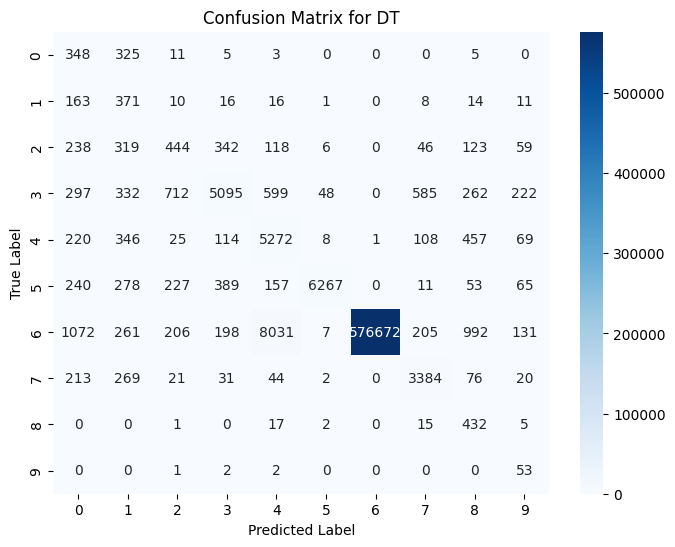

In [33]:
dt_acc =evaluate_result(y_test, dt_y_test_pred, 'DT')

In [34]:
with open(model_path+'my_dt.pkl', 'wb') as f:
    pickle.dump(dt_classifier, f)

## Logistic Regression


In [35]:
# import numpy
# from sklearn import linear_model

# #Reshaped for Logistic function.
# # X = numpy.array([3.78, 2.44, 2.09, 0.14, 1.72, 1.65, 4.92, 4.37, 4.96, 4.52, 3.69, 5.88]).reshape(-1,1)
# # y = numpy.array([0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1])

# logr = linear_model.LogisticRegression()
# logr.fit(x_train,y_train)

# #predict if tumor is cancerous where the size is 3.46mm:
# # predicted = logr.predict(numpy.array([3.46]).reshape(-1,1))
# # print(predicted)

In [36]:
# lr_y_test_pred = logr.predict(x_test)
# lr_acc =evaluate_result(y_test, lr_y_test_pred, 'LR')

In [37]:
# with open('datasets/final_UNSW-NB15/my_lr.pkl', 'wb') as f:
#     pickle.dump(logr, f)

## Random Forest

In [38]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.datasets import make_classification
# X, y = make_classification(n_samples=1000, n_features=4,
#                            n_informative=2, n_redundant=0,
#                            random_state=0, shuffle=False)

start_time = time.time() 
rf_clf = RandomForestClassifier(**my_params['rf_params'],n_jobs=-1)
rf_clf.fit(x_train,y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 771.1640 seconds


In [39]:

start_time = time.time() 

rf_y_test_pred=rf_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 2.8098 seconds


+--------------------+--------------------+--------------------+-----------------+
|      Accuracy      |     Precision      |       Recall       |        F1       |
+--------------------+--------------------+--------------------+-----------------+
| 0.9778287090540055 | 0.9863195541051376 | 0.9778287090540055 | 0.9811922007761 |
+--------------------+--------------------+--------------------+-----------------+


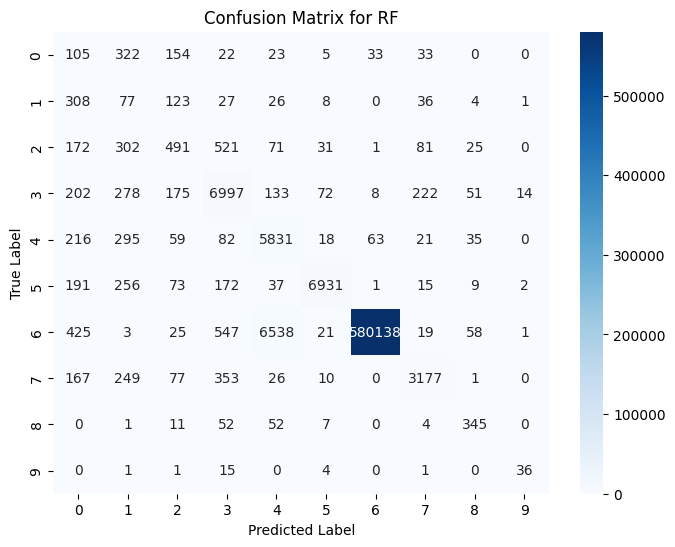

In [40]:
lr_acc =evaluate_result(y_test, rf_y_test_pred, 'RF')

In [41]:
with open(model_path+'my_rf.pkl', 'wb') as f:
    pickle.dump(rf_clf, f)

## XGBoost

In [42]:
from xgboost import XGBClassifier
# read data
# from sklearn.datasets import load_iris
# from sklearn.model_selection import train_test_split
# data = load_iris()
# X_train, X_test, y_train, y_test = train_test_split(data['data'], data['target'], test_size=.2)
# create model instance

start_time = time.time() 
bst = XGBClassifier(**my_params['xgb_params'],n_jobs=-1)
# fit model
bst.fit(x_train, y_train)


training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 413.1493 seconds


In [43]:

start_time = time.time() 

xgb_y_test_pred=bst.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 1.4380 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9745122413106603 | 0.9864629661121908 | 0.9745122413106603 | 0.9791342430913355 |
+--------------------+--------------------+--------------------+--------------------+


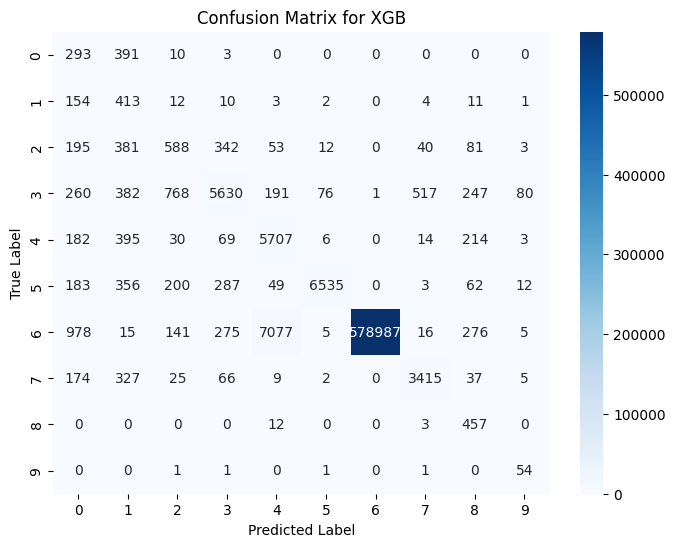

In [44]:
xgb_acc =evaluate_result(y_test, xgb_y_test_pred, 'XGB')

In [45]:
with open(model_path+'my_xgb.pkl', 'wb') as f:
    pickle.dump(bst, f)

## Ensemble

In [46]:
from sklearn.ensemble import VotingClassifier
# Initializing all the 3 classifiers with best found parameters

start_time = time.time() 
dt_clf = DecisionTreeClassifier(**my_params['dt_params'])
rf_clf = RandomForestClassifier(**my_params['rf_params'], n_jobs=-1)
xgb_clf = xgb.XGBClassifier(**my_params['xgb_params'], n_jobs=-1)
v_clf = VotingClassifier(estimators=[('lr', dt_clf), ('rf', rf_clf), ('xgb', xgb_clf)], voting='soft', n_jobs=-1)

v_clf.fit(x_train, y_train)

training_time = time.time() - start_time  

print(f"Training time: {training_time:.4f} seconds")

Training time: 1238.4442 seconds


In [47]:
start_time = time.time() 

v_clf_y_test_pred=v_clf.predict(x_test)

prediction_time = time.time() - start_time  

print(f"Prediction time: {prediction_time:.4f} seconds")

Prediction time: 4.3318 seconds


+--------------------+--------------------+--------------------+--------------------+
|      Accuracy      |     Precision      |       Recall       |         F1         |
+--------------------+--------------------+--------------------+--------------------+
| 0.9752389831441215 | 0.9866373082432665 | 0.9752389831441215 | 0.9798013477285017 |
+--------------------+--------------------+--------------------+--------------------+


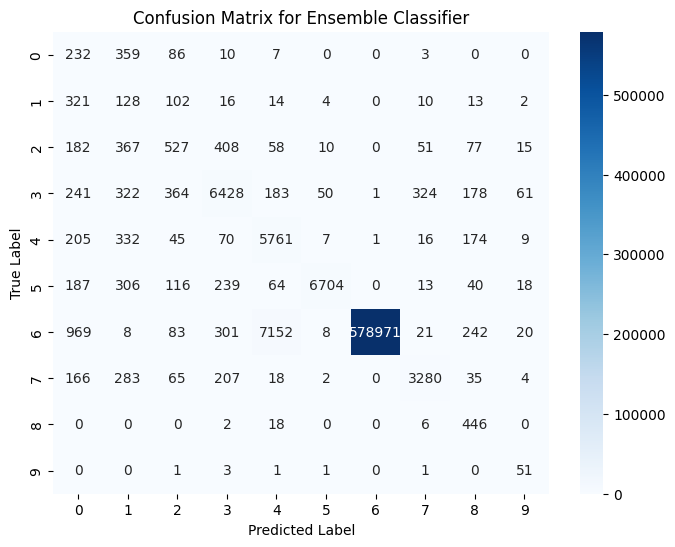

In [48]:
v_clf_acc =evaluate_result(y_test, v_clf_y_test_pred, 'Ensemble Classifier')

In [49]:
with open(model_path+'my_ensemble_clf.pkl', 'wb') as f:
    pickle.dump(v_clf, f)